# Mapillary image dataset

This notebook aims at presenting the [Mapillary](https://www.mapillary.com/dataset/vistas) dataset. This dataset is used for semantic segmentation purpose.

## Introduction

Some modules are imported to do the job, as usual:

In [2]:
import numpy as np
import os
import pandas as pd
import json
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from deeposlandia import aggregate_label, utils, dataset

In [4]:
DATAPATH = "../data"
DATASET = "mapillary"

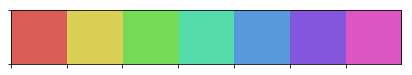

In [5]:
palette = sns.color_palette('hls', 7)
sns.palplot(palette)

## Metadata presentation

### Raw dataset

The dataset contains 25000 street-scene images:
- 18000 in training dataset;
- 2000 in validation dataset;
- 5000 in testing dataset.

In [6]:
print("Number of training images: {}".format(len(os.listdir(os.path.join(DATAPATH, DATASET, "input", "training", "images")))))
print("Number of validation images: {}".format(len(os.listdir(os.path.join(DATAPATH, DATASET, "input", "validation", "images")))))
print("Number of testing images: {}".format(len(os.listdir(os.path.join(DATAPATH, DATASET, "input", "testing", "images")))))

Number of training images: 18000
Number of validation images: 2000
Number of testing images: 5000


This dataset has a quite unpractical feature, as the image size is not standardized. For example, the validation image sizes are as follows:

In [7]:
folder = os.path.join(DATAPATH, DATASET, "input", "validation", "images")
image_filepaths = [os.path.join(folder, image_filename) for image_filename in os.listdir(folder)]
sizes = [Image.open(filename).size for filename in image_filepaths]

In [8]:
df_sizes = pd.DataFrame(sizes, columns=["width", "height"])

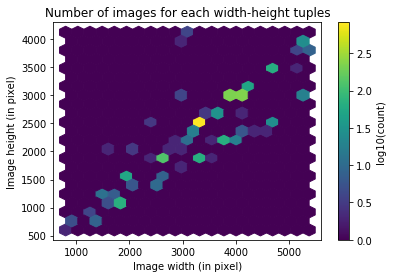

In [9]:
f, ax = plt.subplots(1, 1)
hb = ax.hexbin(df_sizes['width'], df_sizes['height'], gridsize=20, bins='log')
ax.set_title("Number of images for each width-height tuples")
ax.set_xlabel("Image width (in pixel)")
ax.set_ylabel("Image height (in pixel)")
cb = f.colorbar(hb, ax=ax)
cb.set_label('log10(count)')

### Image preprocessing

#### Image size

In order to soften the image size constraint, a multi-step image preprocessing is undertaken:
- a divisible-per-16 image size is picked (*i.e.* 224, 256, 400);
- images are resized so as the smallest side fits the previously chosen size;
- a random crop is applied in order to get square image.

As a result, we get 25000 `n*n` images, with `n` the chosen output image size.

#### Label agregation

As denoted in [another notebook](./Mapillary_label_analysis.ipynb), the Mapillary dataset labels may be aggregated to undertake an easier segmentation process. Instead of considering the 66 original labels, 11 more generic ones are used to describe the pictures.

An extract of the label aggregation is showed below:

In [10]:
config = utils.read_config(os.path.join(DATAPATH, DATASET, "preprocessed", "224_aggregated", "training.json"))
labels = [(item['name'][0], item['contains']) for item in config["labels"]]
pd.DataFrame(labels, columns=["aggregate labels", "original labels"])

,aggregate labels,original labels
0,a,bird...ground-animal
1,b,curb...fence...guard-rail...other-barrier...wall
2,f,bike-lane...crosswalk-plain...curb-cut...parki...
3,h,person
4,m,crosswalk-zebra...general
5,n,mountain...sand...sky...snow...terrain...veget...
6,o,banner...bench...bike-rack...billboard...catch...
7,r,bicyclist...motorcyclist...other-rider
8,s,bridge...building...tunnel
9,s,pole...traffic-sign-frame...utility-pole


In the following cells, we will use `aggregated` keyword to refer to such a preprocessed dataset, whilst `full` will refer to a dataset with all original labels.

## Some examples

In [11]:
def show_example_image(image_filename, image_size, aggregation=False):
    aggregation = "aggregated" if aggregation else "full"
    im = Image.open(os.path.join(DATAPATH, DATASET, "preprocessed", str(image_size)+"_"+aggregation, "training", "images", image_filename+".jpg"))
    lab = Image.open(os.path.join(DATAPATH, DATASET, "preprocessed", str(image_size)+"_"+aggregation, "training", "labels", image_filename+".png"))
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(im)
    ax[1].imshow(lab)

- An original mapillary image: 

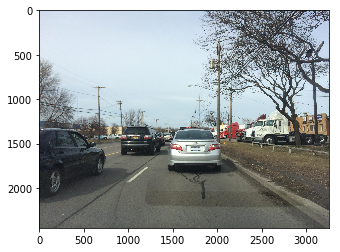

In [12]:
im = Image.open(os.path.join(DATAPATH, DATASET, "input", "training", "images", "0035fkbjWljhaftpVM37-g.jpg"))
plt.imshow(im)

- The picture with original labels:

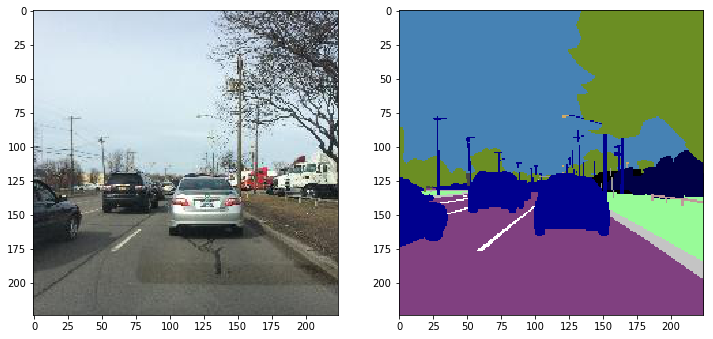

In [13]:
show_example_image("0035fkbjWljhaftpVM37-g", 224)

- The same picture with aggregated labels and a larger size (details are less pixellized):

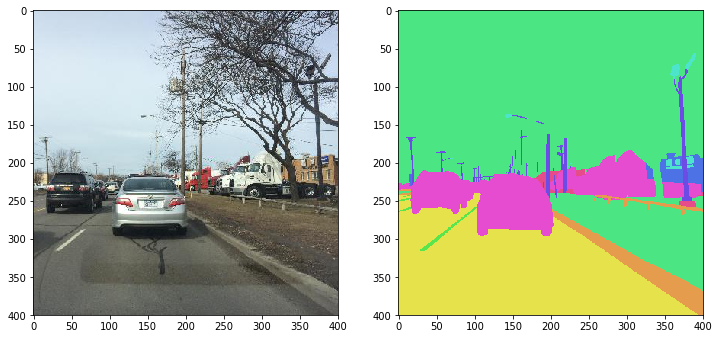

In [14]:
show_example_image("0035fkbjWljhaftpVM37-g", 400, aggregation=True)

## Dataset handling

One may create a shape dataset easily in two steps. First one has to declare an instance of `MapillaryDataset`, by passing an image size and an original `json` configuration file as parameters.

In [16]:
input_folder = utils.prepare_input_folder(DATAPATH, DATASET)
preprocess_folder = utils.prepare_preprocessed_folder(DATAPATH, DATASET, 400, "aggregated")

In [17]:
config_filename = os.path.join(input_folder, "config_aggregate.json")
d = dataset.MapillaryDataset(224, config_filename)

At this step, there is not any image in the dataset, however, the label glossary is seeable.

In [18]:
[item['name'] for item in d.label_info]

['animal',
 'barrier',
 'flat',
 'human',
 'marking',
 'nature',
 'object',
 'rider',
 'structure',
 'support',
 'traffic-sign',
 'vehicle',
 'void']

Then, the dataset must be fillet out with some brand new images. One may specify the image quantity, as well as an output directory if one wants to write these images onto the disk:

In [20]:
d.populate(output_dir=preprocess_folder["training"],
           input_dir=os.path.join(input_folder, "training"),
           nb_images=10,
           aggregate=True)
d.get_nb_images()

10

The dataset may also be loaded starting from an existing dataset: by picking a `.json` configuration file stored in the `preprocessed` folder, one may recover some previously generated files.

In [21]:
preprocess_folder = utils.prepare_preprocessed_folder(DATAPATH, DATASET, 224, "aggregated")
config_filename = preprocess_folder["training_config"]
d.load(config_filename, 5)
d.get_nb_images()

2018-08-22 14:06:03,869 :: INFO :: dataset :: load : The dataset has been loaded from ../data/mapillary/preprocessed/224_aggregated/training.json


5